In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

from custom_transformer import DropNullColumns, TrimmColumns

In [3]:
df_raw = pd.read_csv('data_v1.csv', sep=';')
df_raw.head()

,WEB_PROPERTY_CODE,PRICE,PRICE_ADMIN_INCLUDED,AREA,LATITUDE,LONGITUDE,ANTIQUITY,CONSTRUCTION_YEAR,BUILT_AREA,PRIVATE_AREA,GARAGE,BATHROOMS,ROOMS,FLOOR,PROPERTY_TYPE,OPERATION_TYPE,STRATUM,BEDROOMS
0,192688170,2300000000,2302200000,268.0,4.702433,-74.035299,De 16 a 30 años,NaN,268.0,268.0,3,4,0,6.0,Apartamento,Venta,6,3
1,4828374,199999000,199999000,49.0,4.570417,-74.099243,NaN,NaN,49.0,42.0,0,2,0,0.0,Apartamento,Venta,2,3
2,191798455,333900000,334200000,44.0,4.646693,-74.067000,NaN,NaN,44.0,0.0,1,1,0,5.0,Apartamento,Venta,4,1
3,192594335,460000000,460477000,90.0,4.730525,-74.062372,Más de 30 años,NaN,90.0,90.0,1,2,3,3.0,Apartamento,Venta,5,3
4,192668352,760000000,760915000,81.0,4.675249,-74.047173,Más de 30 años,NaN,81.0,81.0,1,2,2,0.0,Apartamento,Venta,6,2


In [29]:
y_column = ['PRICE']

numeric_features = [
    'AREA',
    'BUILT_AREA',
    'PRIVATE_AREA',
    'LATITUDE',
    'LONGITUDE',
    'FLOOR'
]

categorical_features = [
    'ANTIQUITY',
    'GARAGE',
    'BATHROOMS',
    'ROOMS',
    'STRATUM',
    'BEDROOMS'
]
all_features = numeric_features + categorical_features

df = df_raw.loc[:,y_column + all_features]

### Encoding of variables

In [30]:
# Data Analysis and Quality Check
print("Dataset shape:", df.shape)
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
# df.describe().T.map(lambda x: f"{x:,.0f}")


Dataset shape: (26150, 13)

Data types:
PRICE             int64
AREA            float64
BUILT_AREA      float64
PRIVATE_AREA    float64
LATITUDE        float64
LONGITUDE       float64
FLOOR           float64
ANTIQUITY        object
GARAGE            int64
BATHROOMS         int64
ROOMS             int64
STRATUM           int64
BEDROOMS          int64
dtype: object

Missing values:
PRICE             0
AREA              0
BUILT_AREA        1
PRIVATE_AREA      7
LATITUDE          0
LONGITUDE         0
FLOOR           640
ANTIQUITY       563
GARAGE            0
BATHROOMS         0
ROOMS             0
STRATUM           0
BEDROOMS          0
dtype: int64

Basic statistics:


In [31]:
for c in categorical_features:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].fillna(999)
    elif pd.api.types.is_object_dtype(df[c]):
        df[c] = df[c].fillna('No se sabe')

df[categorical_features] = df[categorical_features].astype('category')

df = df[df['FLOOR'] != 202]
df = df[df['STRATUM'] != 101]

df.dropna(inplace=True)
print(df.dtypes)
print(len(df))
df.head(3)


PRICE              int64
AREA             float64
BUILT_AREA       float64
PRIVATE_AREA     float64
LATITUDE         float64
LONGITUDE        float64
FLOOR            float64
ANTIQUITY       category
GARAGE          category
BATHROOMS       category
ROOMS           category
STRATUM         category
BEDROOMS        category
dtype: object
25508


,PRICE,AREA,BUILT_AREA,PRIVATE_AREA,LATITUDE,LONGITUDE,FLOOR,ANTIQUITY,GARAGE,BATHROOMS,ROOMS,STRATUM,BEDROOMS
0,2300000000,268.0,268.0,268.0,4.702433,-74.035299,6.0,De 16 a 30 años,3,4,0,6,3
1,199999000,49.0,49.0,42.0,4.570417,-74.099243,0.0,No se sabe,0,2,0,2,3
2,333900000,44.0,44.0,0.0,4.646693,-74.067000,5.0,No se sabe,1,1,0,4,1


### New Features

/home/golo/Documents/Proyectos/InmueblesApp/.venv/lib64/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='PRICE', ylabel='Count'>

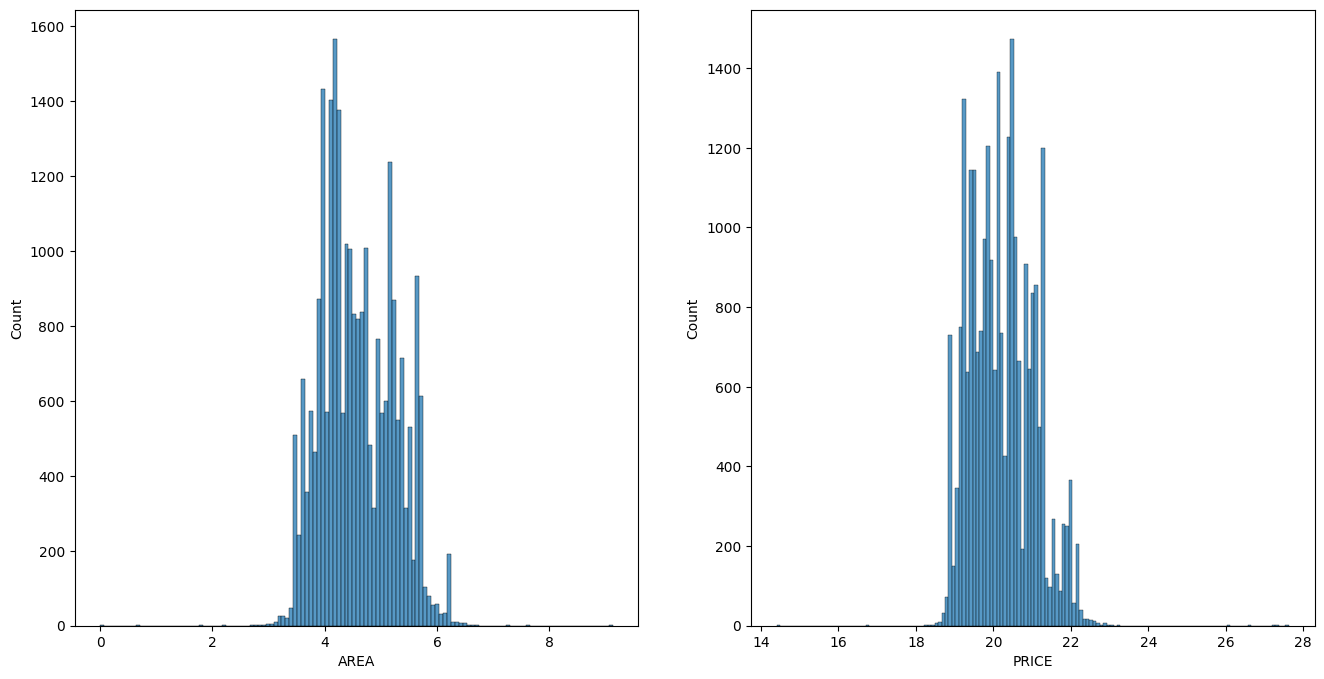

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (16,8))

sns.histplot(x = np.log(df['AREA']), ax = axes[0])
sns.histplot(x = np.log(df['PRICE']), ax = axes[1])

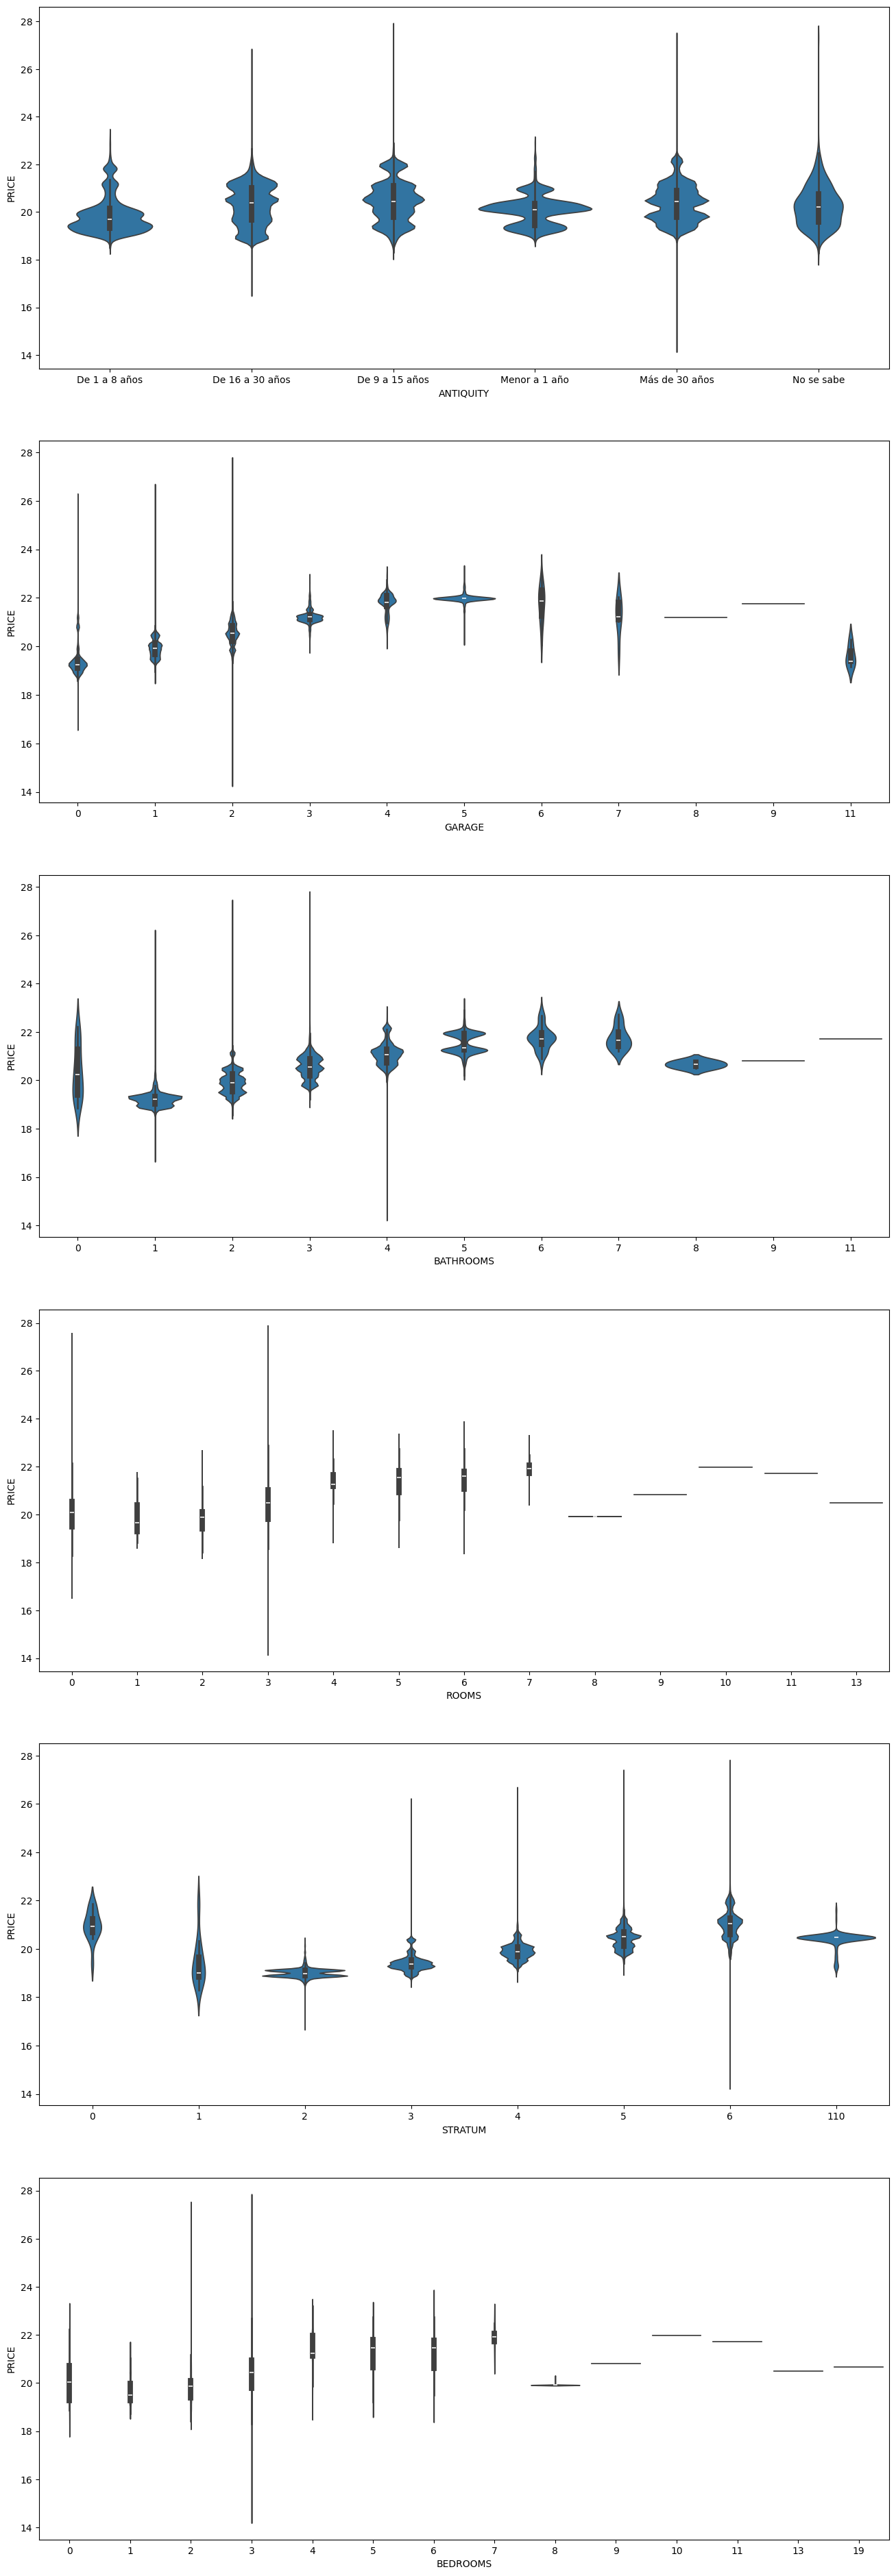

In [33]:
fig, axes = plt.subplots(len(categorical_features), 1, figsize = (16, 8 * len(categorical_features)))
for i, var in enumerate(categorical_features):
    sns.violinplot(df, x = var, y = np.log(df['PRICE']), ax = axes[i])

In [34]:

# DELETE PIPELINE
cutter = Pipeline([
    ('dropna', DropNullColumns()),
    ('trimmer', TrimmColumns(['AREA','PRICE'], tail = 'upper')),  
])

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    # ("log_transform", FunctionTransformer(np.log1p, validate=True)),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

X_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

y_preprocessor = Pipeline([
    ("log_transform", FunctionTransformer(np.log, inverse_func = np.exp)),
    ("scaler", StandardScaler())
])

In [36]:
# df_final = cutter.fit_transform(df)
df_final = df.copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df_final[all_features], df_final[y_column], test_size=0.2, random_state=42)

X_train_processed = X_preprocessor.fit_transform(X_train)
y_train_processed = y_preprocessor.fit_transform(y_train)
X_test_processed = X_preprocessor.transform(X_test)

In [37]:
# Model Training and Evaluation
models = {
    'Linear Regression': LinearRegression(),
    # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_processed, y_train_processed)
    y_pred_raw = model.predict(X_test_processed).reshape(-1,1)
    
    y_pred = y_preprocessor.inverse_transform(y_pred_raw)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'MSE': mse, 'R2': r2}
    
    print(f"\n{name} Results:")
    print(f"MAE: ${mae:,.0f}")
    print(f"MSE: ${mse:,.0f}")
    print(f"R² Score: {r2:.4f}")



Linear Regression Results:
MAE: $305,529,391
MSE: $104,322,150,440,600,109,056
R² Score: 0.0052

XGBoost Results:
MAE: $201,055,952
MSE: $104,340,416,513,710,227,456
R² Score: 0.0051
